Gabriel Marcelino
October 16, 2024
NLP Application


# Import Necessary Libraries


In [102]:
import csv
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

# Download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 1: Load Data

In [103]:
# Read train and test data
train_data = pd.read_csv('archive/train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv('archive/test.csv', encoding='ISO-8859-1')

# Drop unnecessary columns if any (assuming 'text' and 'sentiment' are necessary)
train_data = train_data[['text', 'sentiment']]
test_data = test_data[['text', 'sentiment']]

# Handle NaN values in 'text' and 'sentiment' columns
train_data = train_data.dropna(subset=['text', 'sentiment'])
test_data = test_data.dropna(subset=['text', 'sentiment'])

# Step 2. Preprocess and Visualize the Data:

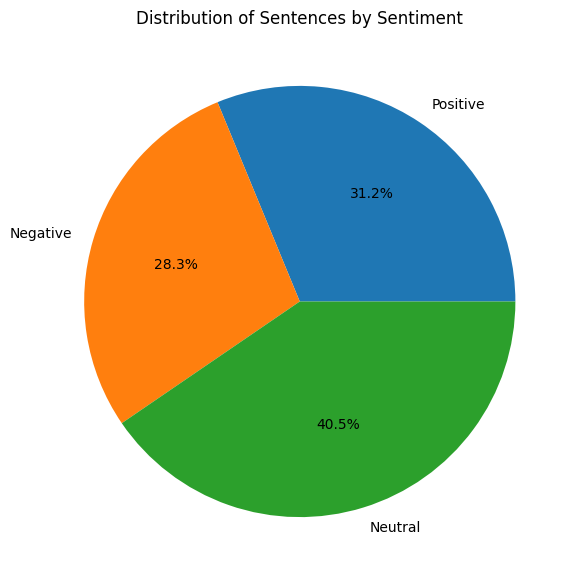

In [104]:
# Count the number of positive, negative, and neutral sentences
num_positives = train_data[train_data['sentiment'] == 'positive'].shape[0]
num_negatives = train_data[train_data['sentiment'] == 'negative'].shape[0]
num_neutral = train_data[train_data['sentiment'] == 'neutral'].shape[0]

# Display count distribution
sentiment_counts = {'Positive': num_positives, 'Negative': num_negatives, 'Neutral': num_neutral}
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%')
plt.title('Distribution of Sentences by Sentiment')
plt.show()

In [105]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, float):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # Remove stop words and lemmatize
    stop_words = set(stopwords.words('english'))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
train_data['cleaned_text'] = train_data['text'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['text'].apply(preprocess_text)

# Step 3: Assign New Sentiment Labels

In [106]:
def map_sentiment(sentiment):
    if sentiment == 'neutral':
        return 0
    elif sentiment == 'negative':
        return -1
    elif sentiment == 'positive':
        return 1

train_data['sentiment'] = train_data['sentiment'].apply(map_sentiment)
test_data['sentiment'] = test_data['sentiment'].apply(map_sentiment)

# Step 4. Feature Extraction

In [107]:
# Combine train and test data for consistency in vectorization
all_data = pd.concat([train_data, test_data])

# Use TfidfVectorizer with bigrams and adjusted parameters
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95, stop_words='english')
X = vectorizer.fit_transform(all_data['cleaned_text'])

# Split features and target
y = all_data['sentiment']

# Step 5: Train-Test Split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Model Building with Logistic *Regression*

In [109]:
model = LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', C=1.0)  # Adjust C for regularization strength
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Step 7: Model Evaluation

In [110]:
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.69


Confusion Matrix:
[[ 991  664   94]
 [ 316 1900  286]
 [  73  505 1374]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.57      0.63      1749
     neutral       0.62      0.76      0.68      2502
    positive       0.78      0.70      0.74      1952

    accuracy                           0.69      6203
   macro avg       0.71      0.68      0.69      6203
weighted avg       0.70      0.69      0.69      6203



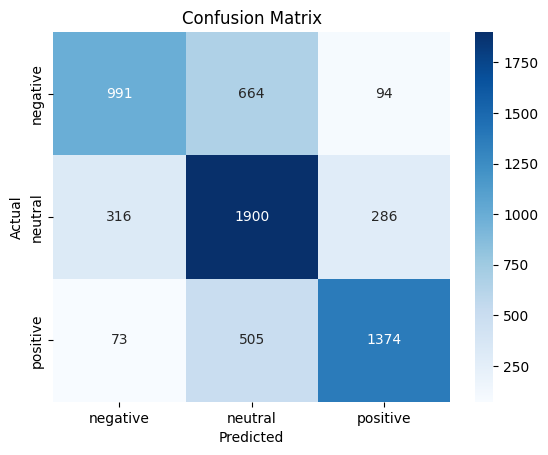

In [111]:
# Generate a confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

# Visualize the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 8: Function to Predict Sentiment of User-Entered Questions

In [101]:
def predict_sentiment(questions):
    # Preprocess the input
    processed_questions = [preprocess_text(question) for question in questions]

    # Convert to TF-IDF features
    question_features = vectorizer.transform(processed_questions)

    # Predict the sentiment
    predictions = model.predict(question_features)

    # Convert numerical predictions to text labels
    sentiment_labels = {0: "neutral", -1: "negative", 1: "positive"}
    readable_predictions = [sentiment_labels[pred] for pred in predictions]

    # Output the results
    for question, sentiment in zip(questions, readable_predictions):
        print(f"Question: '{question}' \nPredicted Sentiment: {sentiment}\n")

# Example usage:
questions = [
    "Is this product worth buying?",
    "I had a terrible experience with the service.",
    "What a fantastic day!",
    "Should I be worried about the side effects?",
    "The instructions were very confusing."
]

predict_sentiment(questions)

Question: 'Is this product worth buying?' 
Predicted Sentiment: positive

Question: 'I had a terrible experience with the service.' 
Predicted Sentiment: negative

Question: 'What a fantastic day!' 
Predicted Sentiment: positive

Question: 'Should I be worried about the side effects?' 
Predicted Sentiment: negative

Question: 'The instructions were very confusing.' 
Predicted Sentiment: neutral

